In [131]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from models import ols_regression, manhattan_linear, gc

In [132]:
def min_max_scaling(X,min_val,max_val):
    X = np.array(X)
    X_min = np.min(X)
    X_max = np.max(X)
    
    # If the column has constant values (min == max), return the original values unscaled
    if X_min == X_max:
        return X
    
    # Perform scaling if min != max
    X_scaled = (X - X_min) / (X_max - X_min) * (max_val - min_val) + min_val

    
    return X_scaled

In [133]:
nr_people_pop1 = 500
nr_people_pop2 = 10
nr_people_pop3 = 300
total_humans = nr_people_pop1+ nr_people_pop2+nr_people_pop3
minaf_pop1 = 0.2
minaf_pop2 = 0.1
minaf_pop3 = 0.1

majaf_pop1 = 0.4
majaf_pop2 = 0.6
majaf_pop3 = 0.1

hetaf_pop1 = 1 - minaf_pop1 - majaf_pop1
hetaf_pop2 = 1 - minaf_pop2 - majaf_pop2
hetaf_pop3 = 1 - minaf_pop3 - majaf_pop3

pheno_pop1 = 0.3
pheno_pop2 = 0.7
pheno_pop3 = 1

In [134]:
# make snp
pop1_snps = [-1]*int(nr_people_pop1*minaf_pop1) + [0]*int(nr_people_pop1*hetaf_pop1) + [1]*int(nr_people_pop1*majaf_pop1)
pop2_snps = [-1]*int(nr_people_pop2*minaf_pop2) + [0]*int(nr_people_pop2*hetaf_pop2) + [1]*int(nr_people_pop2*majaf_pop2)
pop3_snps = [-1]*int(nr_people_pop3*minaf_pop3) + [0]*int(nr_people_pop3*hetaf_pop3) + [1]*int(nr_people_pop3*majaf_pop3)
nr_pop1_snps = [int(nr_people_pop1*minaf_pop1)]*int(nr_people_pop1*minaf_pop1) + [int(nr_people_pop1*hetaf_pop1)]*int(nr_people_pop1*hetaf_pop1) + [int(nr_people_pop1*majaf_pop1)]*int(nr_people_pop1*majaf_pop1)
nr_pop2_snps = [int(nr_people_pop2*minaf_pop2)]*int(nr_people_pop2*minaf_pop2) + [int(nr_people_pop2*hetaf_pop2)]*int(nr_people_pop2*hetaf_pop2) + [int(nr_people_pop2*majaf_pop2)]*int(nr_people_pop2*majaf_pop2)
nr_pop3_snps = [int(nr_people_pop3*minaf_pop3)]*int(nr_people_pop3*minaf_pop3) + [int(nr_people_pop3*hetaf_pop3)]*int(nr_people_pop3*hetaf_pop3) + [int(nr_people_pop3*majaf_pop3)]*int(nr_people_pop3*majaf_pop3)

snps = pop1_snps + pop2_snps + pop3_snps
snps_nr = nr_pop1_snps + nr_pop2_snps + nr_pop3_snps


In [135]:
minaf = [minaf_pop1]*nr_people_pop1 + [minaf_pop2]*nr_people_pop2 + [minaf_pop3]*nr_people_pop3
hetaf = [hetaf_pop1]*nr_people_pop1 + [hetaf_pop2]*nr_people_pop2 + [hetaf_pop3]*nr_people_pop3
majaf = [majaf_pop1]*nr_people_pop1 + [majaf_pop2]*nr_people_pop2 + [majaf_pop3]*nr_people_pop3

In [136]:
pop = ['pop1']*nr_people_pop1 + ['pop2']*nr_people_pop2 +  ['pop3']*nr_people_pop3
pop_nr = [nr_people_pop1]*nr_people_pop1 + [nr_people_pop2]*nr_people_pop2 +  [nr_people_pop3]*nr_people_pop3
risk = [pheno_pop1]*nr_people_pop1 + [pheno_pop2]*nr_people_pop2 +  [pheno_pop3]*nr_people_pop3

In [137]:
humans = pd.DataFrame()
humans['snp'] = snps
humans = pd.get_dummies(humans, columns=['snp'], dtype=int)
humans['snp'] = snps
humans['snp_nr'] = snps_nr
humans['snp_nr'] = humans['snp_nr']/humans['snp_nr'].max()

humans['minaf'] = minaf
humans['hetaf'] = hetaf
humans['majaf'] = majaf
humans['pop'] = pop
humans['pop_quantity'] = pop_nr
humans['risk'] = risk
#humans['risk'] = min_max_scaling(humans['risk'],-1,1)
#humans['risk'] = (humans['risk'] - humans['risk'].mean()) / humans['risk'].std()

In [138]:
pheno_pop1 = humans[humans['pop']=='pop1']['risk'].mean()
pheno_pop2 = humans[humans['pop']=='pop2']['risk'].mean()
pheno_pop3 = humans[humans['pop']=='pop3']['risk'].mean()

In [139]:
count_total_AFs = humans[['snp']].apply(pd.Series.value_counts)/len(humans)
total_minor = count_total_AFs.loc[-1].snp
total_het = count_total_AFs.loc[0].snp
total_major = count_total_AFs.loc[1].snp

In [140]:
total_major

0.291358024691358

In [141]:
"""
humans = humans[humans['snp'] != 0]
count_total_AFs = humans[['snp']].apply(pd.Series.value_counts)/len(humans)
total_minor = count_total_AFs.loc[-1].snp
total_major = count_total_AFs.loc[1].snp
humans
"""

"\nhumans = humans[humans['snp'] != 0]\ncount_total_AFs = humans[['snp']].apply(pd.Series.value_counts)/len(humans)\ntotal_minor = count_total_AFs.loc[-1].snp\ntotal_major = count_total_AFs.loc[1].snp\nhumans\n"

In [142]:
humans['risk'] = humans['risk']-humans['risk'].mean()

In [143]:
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.0728397002567734


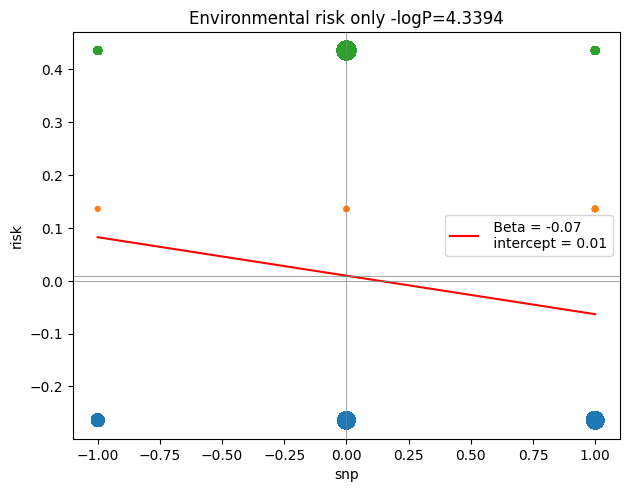

In [144]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, size='snp_nr', hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [145]:
# reproduce with mafs

In [146]:
expected_snp = humans['majaf']-humans['minaf']
variance_snp = humans['minaf']*(1-humans['minaf'])+humans['hetaf']*(1-humans['hetaf'])+humans['majaf']*(1-humans['majaf'])

In [147]:
expected_snp

0      0.2
1      0.2
2      0.2
3      0.2
4      0.2
      ... 
805    0.0
806    0.0
807    0.0
808    0.0
809    0.0
Length: 810, dtype: float64

In [148]:
variance_snp/expected_snp

0      3.2
1      3.2
2      3.2
3      3.2
4      3.2
      ... 
805    inf
806    inf
807    inf
808    inf
809    inf
Length: 810, dtype: float64

In [149]:
humans['snp_variance']=expected_snp/sum(variance_snp)
humans['pheno'] = humans['risk']-humans['risk'].mean()

In [150]:
humans['snp_variance']

0      0.000468
1      0.000468
2      0.000468
3      0.000468
4      0.000468
         ...   
805    0.000000
806    0.000000
807    0.000000
808    0.000000
809    0.000000
Name: snp_variance, Length: 810, dtype: float64

In [151]:
X = humans[['snp_variance']]  # Predictor variable
y = humans['pheno']    # Response variable

# Add a constant to the predictor variable (for intercept)
#X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp_variance']
intercept = 0
p_value = model.pvalues['snp_variance']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

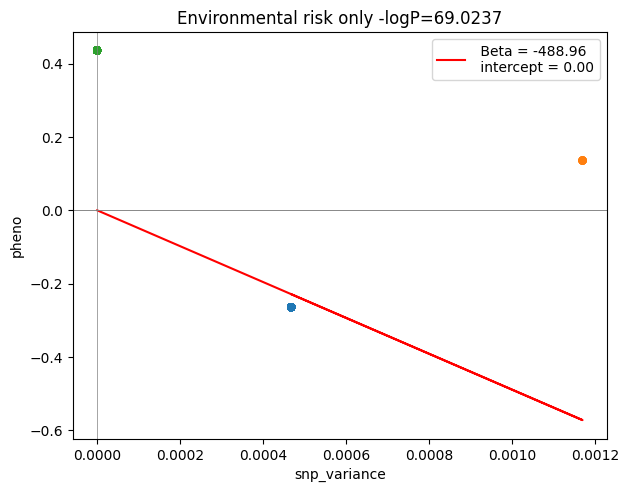

In [152]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp_variance', y='pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp_variance'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# Effect Causal SNP

In [116]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

def multi(arr, effectsize):
    return [num * effectsize for num in arr]

In [117]:
effect = 10

In [118]:
humans['pheno'] = humans['snp']*effect

In [123]:
var_effect = np.var(humans['snp'])
total_variance = var_effect / 0.01
var_noise = total_variance - var_effect
sd_noise = np.sqrt(var_noise)
# Generate phenotype with noise
n = len(humans)
humans['pheno'] = humans['pheno'] + np.random.normal(0, sd_noise,n)

#std_dev = np.std(humans['pheno'])
#mean = np.mean(humans['pheno'])
#humans['pheno'] = (humans['pheno'] - mean) / std_dev

In [124]:
np.random.normal(0, sd_noise)

-1.2260419236616933

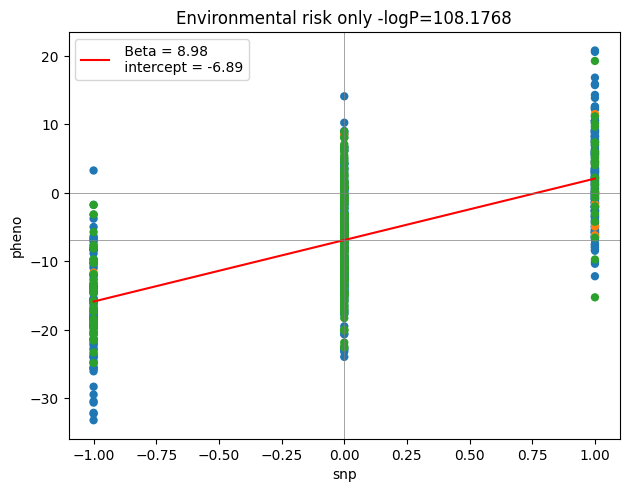

In [126]:
X = humans['snp']
y = humans['pheno']

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_pheno'] = model.predict(X)

# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_pheno'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [ ]:
X = humans['snp']
y = humans['pheno']

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_pheno'] = model.predict(X)

# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_pheno'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

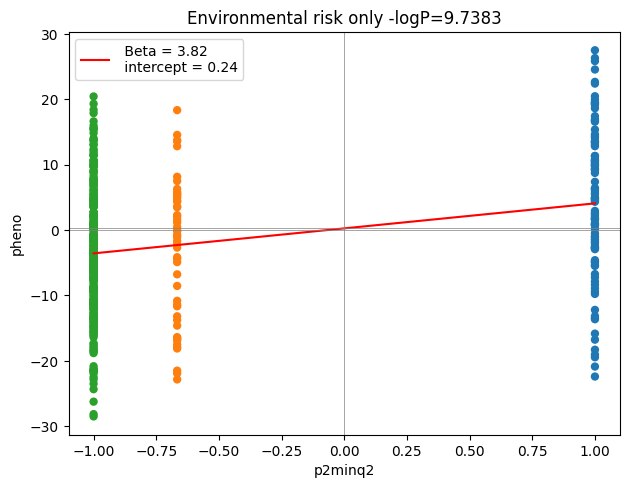

In [116]:
X = humans['p2minq2']
y = humans['pheno']

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['p2minq2']
intercept = model.params['const']
p_value = model.pvalues['p2minq2']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_pheno_p2minq2'] = model.predict(X)

# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='p2minq2', y='pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['p2minq2'], humans['predicted_pheno_p2minq2'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

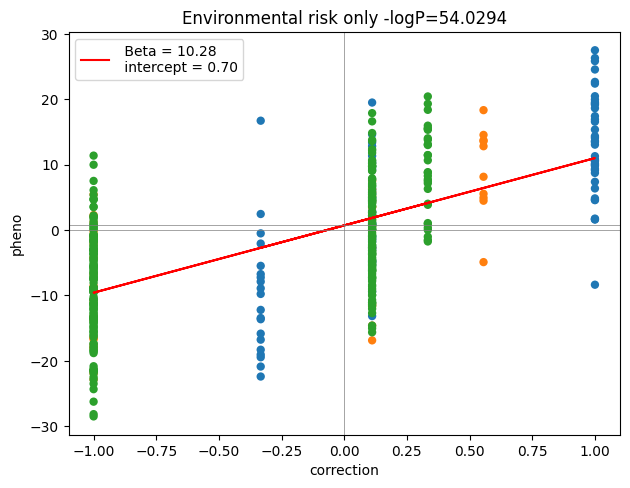

In [118]:
humans['correction'] = humans.apply(lambda row: row['minaf'] if row['snp'] == -1 else (row['hetaf'] if row['snp'] == 0 else row['majaf']), axis=1)
humans['correction'] = humans['correction']*humans['snp']
humans['correction'] = min_max_scaling(humans['correction'],-1,1)
X = humans['correction']
y = humans['pheno']

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['correction']
intercept = model.params['const']
p_value = model.pvalues['correction']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_pheno_correction'] = model.predict(X)

# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='correction', y='pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['correction'], humans['predicted_pheno_correction'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [119]:
# Combination

In [121]:
humans['combined_pheno'] = humans['pheno']+humans['risk']

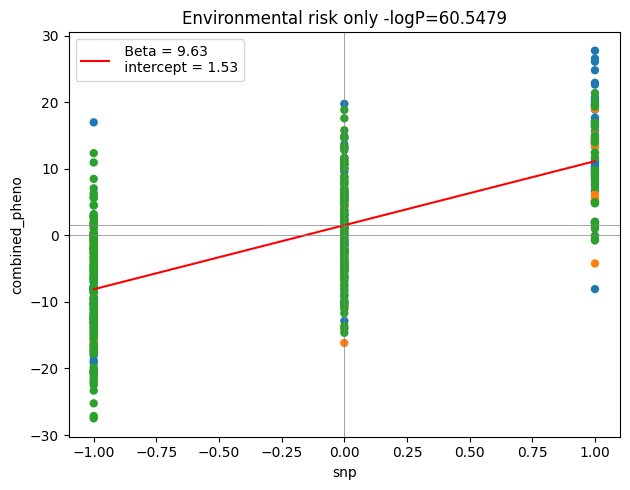

In [122]:
X = humans['snp']
y = humans['combined_pheno']

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_pheno'] = model.predict(X)

# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='combined_pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_pheno'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

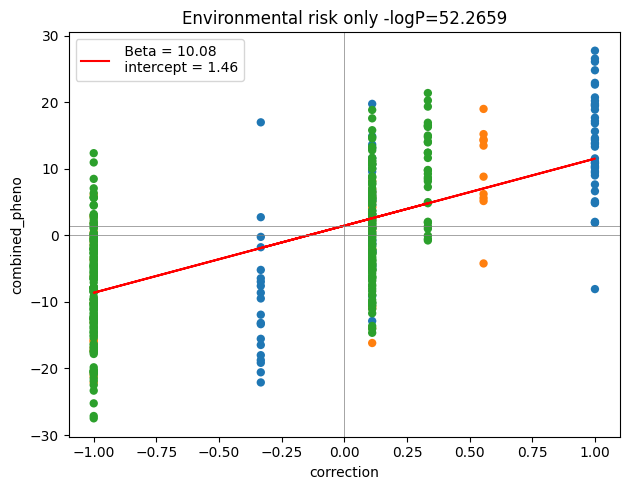

In [123]:
humans['correction'] = humans.apply(lambda row: row['minaf'] if row['snp'] == -1 else (row['hetaf'] if row['snp'] == 0 else row['majaf']), axis=1)
humans['correction'] = humans['correction']*humans['snp']
humans['correction'] = min_max_scaling(humans['correction'],-1,1)
X = humans['correction']
y = humans['combined_pheno']

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['correction']
intercept = model.params['const']
p_value = model.pvalues['correction']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_pheno_correction'] = model.predict(X)

# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='correction', y='combined_pheno', data=humans, hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['correction'], humans['predicted_pheno_correction'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [140]:
humans['snp_AF_05'] = humans['snp']

In [132]:
beta_mafs_ols = manhattan_linear(humans[['snp_AF_05']], humans[['combined_pheno']], humans[['correction']])    
beta_mafs_ols

,snp,coefs,AFs,Ps,-logPs
0,snp,9.659144,05,7.435066e-10,9.128715


In [146]:
beta_mafs_ols = manhattan_linear(humans[['snp_AF_05']], humans[['risk']], humans[['p2minq2']])    
beta_mafs_ols

,snp,coefs,AFs,Ps,-logPs
0,snp,9.055257e-16,05,1.0,8.032848e-14


In [145]:
beta_mafs_ols = manhattan_linear(humans[['snp_AF_05']], humans[['risk']])    
beta_mafs_ols

,snp,coefs,AFs,Ps,-logPs
0,snp,-0.127121,05,1.430830e-12,11.844412
